<a href="https://colab.research.google.com/github/Exoper/Yoga_pose_classification/blob/master/yoga_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import sklearn.preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import seaborn as sns
import cv2
import os 
import time
from skimage.feature import hog
from skimage.transform import AffineTransform, warp,rotate
import random
from PIL import Image
from sklearn.pipeline import make_pipeline
#from Posenet import PoseExtractor
import seaborn as sns
import tensorflow as tf
from sklearn.base import BaseEstimator, TransformerMixin


In [6]:
!unzip "/content/drive/My Drive/dataset.zip" -d "/content/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/ardha pincha mayurasana/55-0.png  
  inflating: /content/dataset/ardha pincha mayurasana/10-0.png  
  inflating: /content/dataset/ardha pincha mayurasana/21-0.png  
  inflating: /content/dataset/ardha pincha mayurasana/38-1.png  
  inflating: /content/dataset/ardha pincha mayurasana/2-0.png  
  inflating: /content/dataset/ardha pincha mayurasana/40-0.png  
  inflating: /content/dataset/ardha pincha mayurasana/42-0.png  
  inflating: /content/dataset/ardha pincha mayurasana/0-0.png  
  inflating: /content/dataset/ardha pincha mayurasana/4-0.png  
  inflating: /content/dataset/ardha pincha mayurasana/27-1.png  
  inflating: /content/dataset/ardha pincha mayurasana/86-0.png  
  inflating: /content/dataset/ardha pincha mayurasana/18-0.png  
  inflating: /content/dataset/ardha pincha mayurasana/83-0.png  
  inflating: /content/dataset/ardha pincha mayurasana/43-0.png  
  inflating: /content/dataset/ardha pincha

Data creation

In [2]:
# Dataframe creation
path = "/content/dataset/"
image_path = []
for directory,subdir,files in os.walk(path):
  print(directory)
  for f in files:
    if f.endswith('.png') or f.endswith('jpg'):
      label = directory.split('/')[-1]
      image_path.append([("/").join(("/content/dataset",label,f)),label])
data = pd.DataFrame(image_path,columns=['image_path','label'])     # dataframe containing images and labels


/content/dataset/
/content/dataset/mayurasana
/content/dataset/padmasana
/content/dataset/makara adho mukha svanasana
/content/dataset/simhasana
/content/dataset/tulasana
/content/dataset/virasana
/content/dataset/bitilasana
/content/dataset/eka pada rajakapotasana
/content/dataset/anjaneyasana
/content/dataset/phalakasana
/content/dataset/virabhadrasana iii
/content/dataset/kurmasana
/content/dataset/utthita parsvakonasana
/content/dataset/garudasana
/content/dataset/ardha uttanasana
/content/dataset/utthita trikonasana
/content/dataset/hanumanasana
/content/dataset/paripurna navasana
/content/dataset/ardha chandrasana
/content/dataset/savasana
/content/dataset/padangusthasana
/content/dataset/pincha mayurasana
/content/dataset/marichyasana i
/content/dataset/ganda bherundasana
/content/dataset/salabhasana
/content/dataset/bhairavasana
/content/dataset/salamba bhujangasana
/content/dataset/bharadvajasana i
/content/dataset/supta baddha konasana
/content/dataset/ardha matsyendrasana
/c

Visualization of Dataset

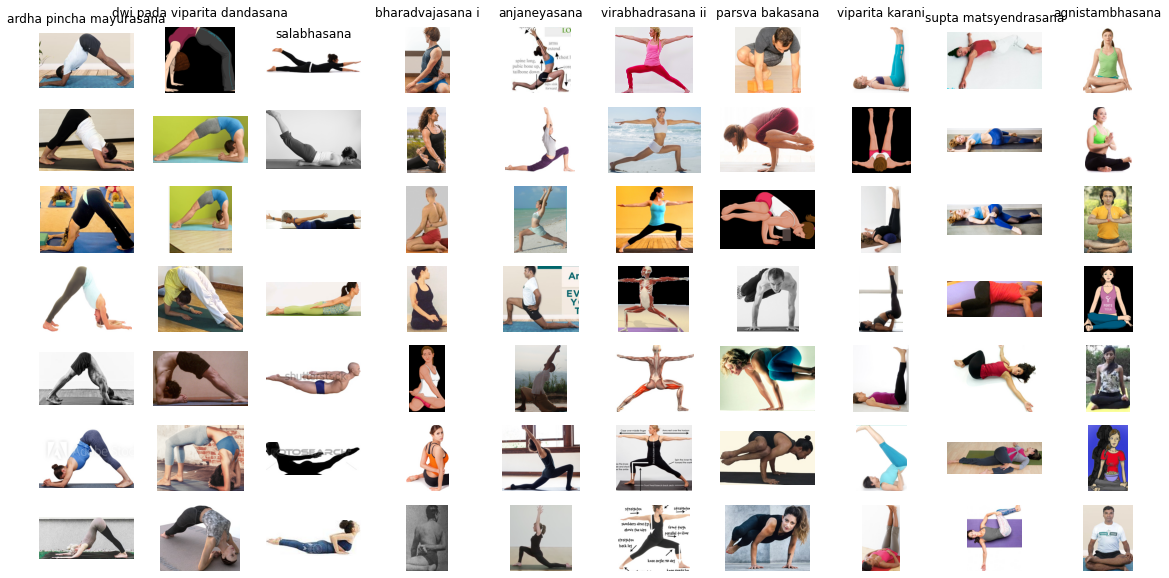

In [3]:
path = '/content/dataset/'
classes = data['label'].unique()
classes = np.random.choice(classes,10,replace = False)
plt.figure(figsize=(20,10))
for y,cls in enumerate(classes):
  idx = np.flatnonzero(data['label'] == cls)
  idx = np.random.choice(idx,7,replace=False)

  for i,id1 in enumerate(idx):
    plt_id = i*(len(classes)) + y + 1
    
    plt.subplot(7,len(classes),plt_id)
    img = cv2.imread(os.path.join(path,data['label'][id1],data['image_path'][id1]))
    plt.imshow(img[:,:,[2,1,0]])
    plt.axis('off')
    if i == 0:
      plt.title(cls,pad=10)

plt.show()

In [0]:
from PIL import Image
import tensorflow as tf
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class PoseExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, model_path='/content/pose.tflite'):
        self.model_path = model_path
        self.interpreter = tf.lite.Interpreter(model_path=self.model_path)
        self.interpreter.allocate_tensors()
        
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()
        _, self.input_dim, _, _ = self.input_details[0]['shape']
        _, self.mp_dim, _, self.ky_pt_num = self.output_details[0]['shape']
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        '''
        X is an iterable listing image paths or numpy arrays
        '''
        feat_array = []
        filepath = True if isinstance(X[0], str) else False
        for row in X:

            # Read image and resize for model
            image = Image.open(row) if filepath else Image.fromarray(row)

            image = image.resize((self.input_details[0]['shape'][1],self.input_details[0]['shape'][2]), Image.NEAREST)
            image = np.expand_dims(np.asarray(image).astype(self.input_details[0]['dtype'])[:, :, :3], axis=0)
            print(self.input_details)
            print(self.output_details)
            # Run inference
            self.interpreter.set_tensor(self.input_details[0]['index'], image)
            self.interpreter.invoke()
            result = self.interpreter.get_tensor(self.output_details[0]['index'])

            # Process result and create feature array
            res = result.reshape(1, self.mp_dim**2, self.ky_pt_num)
            max_idxs = np.argmax(res, axis=1)
            coords = list(map(lambda x: divmod(x, self.mp_dim), max_idxs))
            feature_vec = np.vstack(coords).T.reshape(2 * self.ky_pt_num, 1)
            feat_array.append(feature_vec)

        return np.array(feat_array).squeeze()

In [0]:
## Baseline SVM model with 2 labels
pipeline = Pipeline([
               ('pose_extractor', PoseExtractor()),     # pose extractor
               ('classifier', SVC())])                  # classifier

def svctrain(x_train, x_test, y_train, y_test):
    pipeline.fit(x_train, y_train)

def svctrainResults(x_train, x_test, y_train, y_test):
    
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    return accuracy_score(y_pred, y_test),y_pred,y_test

def train_data_base(df):

  X = df['image_path'].values
  y = df['label']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  svctrain(X_train,X_test,y_train,y_test)
  acc,pred,y_test = svctrainResults(X_train,X_test,y_train,y_test)
  return acc,pred,y_test

In [6]:
# 2 class classification model
label_encoder = sklearn.preprocessing.LabelEncoder() 
label = ['virabhadrasana iii','garudasana']               # training particularly for selected labels
df0 = data[(data['label']==label[0]) | (data['label']==label[1])]
df0['label']= label_encoder.fit_transform(df0['label']) 
accuracy,pred,y_test = train_data_base(df0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


[{'name': 'image', 'index': 530, 'shape': array([  1, 192, 192,   3], dtype=int32), 'shape_signature': array([  1, 192, 192,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'Convolutional_Pose_Machine/stage_5_out', 'index': 284, 'shape': array([ 1, 96, 96, 14], dtype=int32), 'shape_signature': array([ 1, 96, 96, 14], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'image', 'index': 530, 'shape': array([  1, 192, 192,   3], dtype=int32), 'shape_signature': array([  1, 192, 192,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array(

In [7]:
accuracy    # accuracy

0.9642857142857143

In [8]:
print(classification_report(y_test,pred))                # classification report

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       1.00      0.92      0.96        12

    accuracy                           0.96        28
   macro avg       0.97      0.96      0.96        28
weighted avg       0.97      0.96      0.96        28



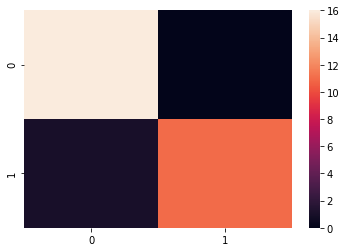

In [9]:
conf0 = confusion_matrix(y_test,pred)                              # confusion report 
sns.heatmap(conf0)
plt.show()

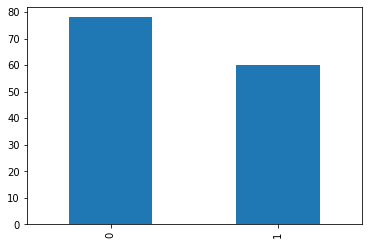

In [10]:
df0.label.value_counts().plot(kind='bar');                  # label frequency

[{'name': 'image', 'index': 530, 'shape': array([  1, 192, 192,   3], dtype=int32), 'shape_signature': array([  1, 192, 192,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'Convolutional_Pose_Machine/stage_5_out', 'index': 284, 'shape': array([ 1, 96, 96, 14], dtype=int32), 'shape_signature': array([ 1, 96, 96, 14], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
<class 'numpy.ndarray'>
(28,)
[16 48 28 48 28 40 16 40  4 40 32 60  8 60  4 52 52 40 72 40 88 40 52 52
 72 52 88 52]


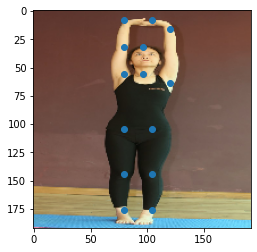

In [11]:
# pose key coordinates from PoseExtractor
extractor = PoseExtractor()
p = "/content/dataset/tadasana/Tadasana.A.jpg"
image = cv2.imread(p)
sample = extractor.transform([image])
print(type(sample))
print(sample.shape)
print(sample)
y = [sample[i] for i in range(sample.shape[0]) if i%2 == 0]
x = [sample[i] for i in range(sample.shape[0]) if i%2 != 0]
kpt_c = np.vstack((x,y)).T
t = cv2.imread(p)
t = cv2.resize(t,(192,192))
scale_ratio = 192.0/96.0
kpt_c = kpt_c*scale_ratio
plt.scatter(kpt_c[:,0],kpt_c[:,1])
plt.imshow(t[:,:,[2,1,0]])
plt.show()

HOG Image - incase we go for image classification

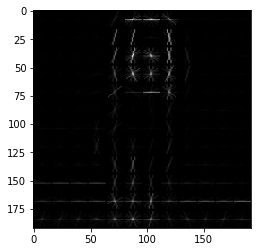

In [13]:
grey_bombus = cv2.cvtColor(t,cv2.COLOR_BGR2GRAY)
hog_features, hog_image = hog(grey_bombus,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))

plt.imshow(hog_image, cmap='gray')

Augmentation

In [0]:
a = np.zeros((192,192))
for i in range(kpt_c.shape[0]):
    kc = kpt_c.astype('int')
    
    a[kc[i][1],kc[i][0]] = 1.0


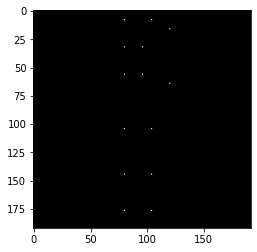

In [15]:
plt.imshow(a,cmap='gray')

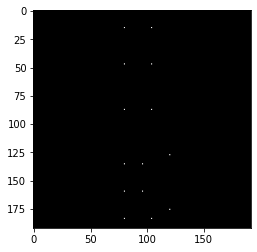

In [16]:
plt.imshow(np.flipud(a),cmap='gray')

In [0]:
# creating dataset 
def create_data(data):
  lst = np.array([[0]]*28)
  li = []
  def pose(data):
    for i in range(data.shape[0]):
      extractor = PoseExtractor()
      path = (data['image_path'].iloc[i])
      image = cv2.imread(path)
      sample = extractor.transform([image])
      yield sample,i
  for sample,i in pose(data):
    label = data['label'].iloc[i]
    li.append(list(sample)+[label])
  return pd.DataFrame(li)



In [13]:
df = create_data(data)

Streaming output truncated to the last 5000 lines.
[{'name': 'Convolutional_Pose_Machine/stage_5_out', 'index': 284, 'shape': array([ 1, 96, 96, 14], dtype=int32), 'shape_signature': array([ 1, 96, 96, 14], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'image', 'index': 530, 'shape': array([  1, 192, 192,   3], dtype=int32), 'shape_signature': array([  1, 192, 192,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'Convolutional_Pose_Machine/stage_5_out', 'index': 284, 'shape': array([ 1, 96, 96, 14], dtype=int32), 'shape_signature': array([ 1, 96, 96, 14], dtype=int32), 'dtype': <class 'numpy.float

In [0]:
df.columns=['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','label']
#df.to_csv("/content/yoga_data.csv") # save to file

In [15]:
df.head()   # complete dataset

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,label
0,0,0,0,0,0,0,64,48,16,8,40,80,40,44,20,12,68,60,72,64,88,76,16,20,72,68,88,76,mayurasana
1,0,88,16,92,16,88,0,0,20,8,16,88,32,8,20,8,40,68,52,60,80,56,40,76,56,64,80,56,mayurasana
2,40,88,44,72,40,72,56,60,40,68,48,68,60,60,80,60,56,36,72,24,72,4,60,32,68,24,72,4,mayurasana
3,24,44,20,48,24,44,56,24,92,48,24,40,36,40,92,48,52,48,68,56,92,48,48,44,68,56,68,72,mayurasana
4,80,32,76,32,72,40,24,72,12,80,76,24,20,72,12,76,44,52,84,0,92,44,40,64,28,72,92,44,mayurasana


Preparing data for for 2 class and multi-class classifer:


*   Dataframe with keyposition coordinates
*   Dataframe with augmented datapoints







In [16]:
# preparing data for 2 class classifier
df0 = df[(df['label']==label[0]) | (df['label']==label[1])]
df0['label']= label_encoder.fit_transform(df0['label']) 
df0.head()
df0.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(138, 29)

In [17]:
# multi label data
label_map = {'balasana':2,'virabhadrasana ii':1,'tadasana':3}
df1 = df[(df['label'] == 'balasana') | (df['label'] == 'tadasana')| (df['label']=='virabhadrasana ii')]
df1['label'] = df1['label'].map(label_map)
df1.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,label
2183,0,0,72,76,0,0,0,0,0,0,0,8,84,24,52,84,40,92,0,0,0,0,0,0,0,0,0,0,3
2184,0,44,16,48,20,36,36,32,44,28,20,56,32,60,44,64,48,40,64,40,84,44,48,52,68,48,84,48,3
2185,16,48,28,48,28,40,16,40,4,40,32,60,8,60,4,52,52,40,72,40,88,40,52,52,72,52,88,52,3
2186,16,48,28,48,32,36,24,28,4,40,28,60,16,64,4,60,52,36,68,32,88,32,52,56,68,56,88,56,3
2187,0,0,0,0,52,28,0,0,0,0,0,44,56,52,60,48,64,36,68,36,88,48,64,44,68,44,88,48,3


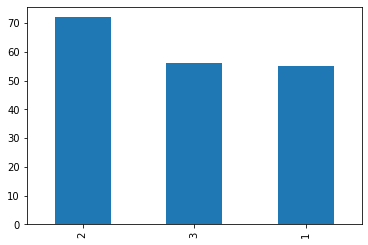

In [18]:
df1.label.value_counts().plot(kind='bar');

In [0]:
# Augmentation
def kp_rotate(vec, shift=0.2):
    v = vec.copy()
    v -= [46,46]
    N = np.linalg.norm(v)
    n_theta = np.arctan(v[1] / v[0]) - shift
    return np.array([int(np.cos(n_theta)* N), int(np.sin(n_theta)* N)])
def apply_rot(vec,shift = 0.2):
  return np.apply_along_axis(kp_rotate, 1 , vec).flatten()

def h_flip(image):
    return  np.fliplr(image).flatten()

def v_flip(image):
    return np.flipud(image).flatten()

def x_shift(image):
  val = np.random.randint(-20,20)
  coords = np.array([[1,0]]*14)
  out = image + coords * val
  return out.flatten()

def y_shift(image):
  val = np.random.randint(-10,10)
  coords = np.array([[0,1]]*14)
  out = image + coords * val
  return out.flatten()
transformations = {'rotation': apply_rot,
                      'horizontal flip': h_flip, 
                      'vertical flip': v_flip,
                   'x shift': x_shift,
                   'y_shift': y_shift,
                 }   


In [0]:
# reason for smaller no of augmentations is due to the low size of the images in a class
def augument(df):
  lst = np.array([[0]]*28).T
  li = []
  def pose(data):
  
    for i in range(data.shape[0]):
      sample = df.iloc[i,:-1]
      yield sample,i
  for sample,i in(pose(df[:])):
    print(i)
    y = [sample[i] for i in range(sample.shape[0]) if i%2 == 0]
    x = [sample[i] for i in range(sample.shape[0]) if i%2 != 0]
    label = df['label'].iloc[i]
    kpt_c = np.vstack((x,y)).T
    #print(label)
    n = 3                 # 3 augmentations per image
    j = 1
    while j<= n:    
      transformed_out=None
      #print(label)
      #variable to iterate till number of transformation to apply
      transformation_count = random.randint(1, len(transformations)) #choose random number of transformation to apply on the image
      key = random.choice(list(transformations)) #randomly choosing method to call
      transformed_out = transformations[key](kpt_c)
    
      lst = np.concatenate((lst,np.array([transformed_out])))
      li.append(label)
      #lst.append(list(transformed_out))
      #print(transformed_out)
  
      j+=1
      #lst = lst.dr
      df_1 =  pd.DataFrame(lst)
  df_1 = df_1.drop(df_1.index[0])
  df_1['label'] = li
  return df_1

In [21]:
# 2 classes augmented dataset
df0_aug = augument(df0)
df0_aug.head()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,label
1,37,-46,31,-36,22,-39,21,-26,28,-52,28,-28,19,-14,18,-18,-3,-25,18,22,42,17,2,-18,7,8,14,39,1
2,37,-46,31,-36,22,-39,21,-26,28,-52,28,-28,19,-14,18,-18,-3,-25,18,22,42,17,2,-18,7,8,14,39,1
3,83,8,75,16,67,12,63,24,75,0,71,24,59,36,59,32,39,20,23,20,-1,20,43,28,43,56,43,88,1
4,0,24,12,28,20,28,16,12,16,4,12,28,20,16,16,4,32,52,60,52,88,48,24,60,16,72,16,88,1
5,30,40,24,29,22,21,39,22,47,21,24,29,34,19,47,21,3,-14,8,12,10,40,9,-24,19,-34,35,-37,1


(414, 29)


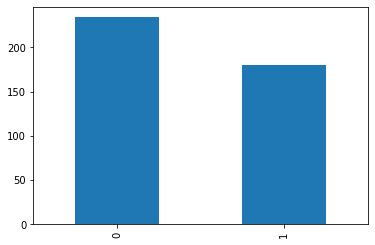

In [22]:
print(df0_aug.shape)
df0_aug.label.value_counts().plot(kind='bar');


In [23]:
df1_aug = augument(df1)
df1_aug.shape
#df_1.to_csv('/content/data_augmented.csv')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182


(549, 29)

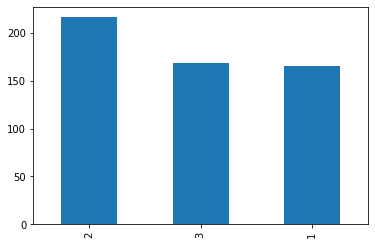

In [24]:
df1_aug['label'].value_counts().plot(kind='bar');


Dataframe representation
1.   df0     ~ Two class dataset of poses
2.   df0_aug ~ Two class augmented dataset
3.   df1     ~ Multi-label (3 labels) dataset
4.   df1_aug ~ Multi-label augmented dataset







In [0]:
# SVM , XGBOOST , MLP

## SVM model

In [0]:
# SVM
from sklearn.model_selection import GridSearchCV

def svm_trainResults(data,param=0):
  
  if param == 0:
    param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
  elif param == 1: 
    param_grid = {'kernel':('linear', 'rbf'), 'C':(1,0.25,0.5,0.75),'gamma': (1,2,3,'auto'),'decision_function_shape':('ovo','ovr'),'shrinking':(True,False)}
  
  elif param == 2:
    param_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}] 

  grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  X = data.iloc[:,:-1]
  y = data.iloc[:,-1]
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)
  # fitting the model for grid search 
  grid.fit(X_train, y_train) 
  pred = grid.predict(X_test)
  print(grid.best_params_)
  return accuracy_score(y_test,pred), classification_report(y_test,pred),confusion_matrix(y_test,pred)


In [56]:
# df0_aug
acc_score_aug,classrep_aug, conf = svm_trainResults(df0_aug) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.597, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.581, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.581, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.581, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.581, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.597, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.645, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.645, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.613, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.613, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.629, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.597, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.629, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] .

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    1.2s finished


0.9134615384615384
              precision    recall  f1-score   support

           0       0.87      0.98      0.92        53
           1       0.98      0.84      0.91        51

    accuracy                           0.91       104
   macro avg       0.92      0.91      0.91       104
weighted avg       0.92      0.91      0.91       104



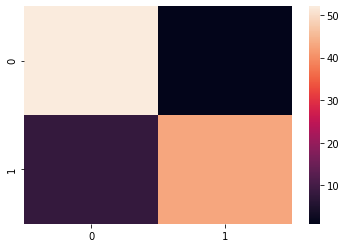

In [58]:
print(acc_score_aug)
print(classrep_aug)
sns.heatmap(conf)

In [59]:
# df1
acc_score1,classrep1,conf1 = svm_trainResults(df1) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.393, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.393, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.407, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.370, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.370, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.393, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.370, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.370, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.571, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.500, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.593, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.556, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.630, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.7s finished


0.9347826086956522
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        11
           2       0.94      0.89      0.92        19
           3       0.88      0.94      0.91        16

    accuracy                           0.93        46
   macro avg       0.94      0.94      0.94        46
weighted avg       0.94      0.93      0.93        46



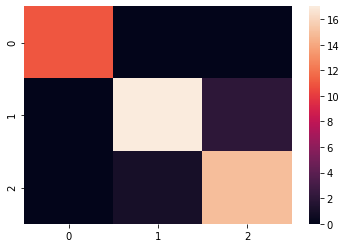

In [60]:
print(acc_score1)
print(classrep1)
sns.heatmap(conf1)

In [61]:
#df1_aug
acc_score1_aug,classrep1_aug,conf1 = svm_trainResults(df1_aug) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.422, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.427, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.427, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.415, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.415, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.422, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.427, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.415, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.415, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.506, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.524, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.488, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.463, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    2.1s finished


0.9492753623188406
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        44
           2       0.89      0.95      0.92        43
           3       0.96      0.90      0.93        51

    accuracy                           0.95       138
   macro avg       0.95      0.95      0.95       138
weighted avg       0.95      0.95      0.95       138



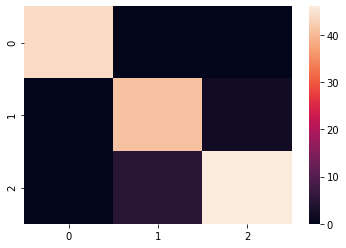

In [62]:
# accuracy improves after augmentation
print(acc_score1_aug)
print(classrep1_aug)
sns.heatmap(conf1)

### MLP Classifier

In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
mlp = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(30,30,30)))
def MLPtrain(x_train, x_test, y_train, y_test):
    global mlp
    mlp.fit(x_train, y_train)

def MLPtrainResults(x_train, x_test, y_train, y_test):
    global mlp
    mlp.fit(x_train, y_train)
    y_pred = mlp.predict(x_test)
    return classification_report(y_test, y_pred)
def run(data):
  X = data.iloc[:,:-1]
  y = data.iloc[:,-1]
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.20,random_state = 42)
  return MLPtrainResults(X_train,X_test,y_train,y_test)

In [65]:
#df0
cls_0 = run(df0)
print(cls_0)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.92      0.92      0.92        12

    accuracy                           0.93        28
   macro avg       0.93      0.93      0.93        28
weighted avg       0.93      0.93      0.93        28



In [66]:
# df0_aug
cls_0aug = run(df0_aug)
print(cls_0aug)

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        39
           1       1.00      0.86      0.93        44

    accuracy                           0.93        83
   macro avg       0.93      0.93      0.93        83
weighted avg       0.94      0.93      0.93        83



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [67]:
#df1
cls_1 = run(df1)
print(cls_1)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         9
           2       0.87      0.87      0.87        15
           3       0.85      0.85      0.85        13

    accuracy                           0.89        37
   macro avg       0.90      0.90      0.90        37
weighted avg       0.89      0.89      0.89        37



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [68]:
# df1_aug
cls_1aug = run(df1_aug)
print(cls_1aug)

              precision    recall  f1-score   support

           1       0.97      1.00      0.99        33
           2       0.87      1.00      0.93        33
           3       1.00      0.86      0.93        44

    accuracy                           0.95       110
   macro avg       0.95      0.95      0.95       110
weighted avg       0.95      0.95      0.95       110



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [0]:
from xgboost import XGBClassifier

def xgbtrain(data):
  X = data.iloc[:,:-1]
  y = data.iloc[:,-1]
  classes = set(y)
  num_class = len(classes)
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.20,random_state = 42)
  clf = make_pipeline(StandardScaler(),XGBClassifier(max_depth=6, 
                    learning_rate=0.01, 
                    n_estimators=500, 
                    objective='multi:softmax',  
                    num_class=num_class))
  clf.fit(X_train,y_train)
  print(num_class)
  pred = clf.predict(X_test)
  return classification_report(y_test,pred),confusion_matrix(y_test,pred)

3
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         9
           2       0.93      0.87      0.90        15
           3       0.86      0.92      0.89        13

    accuracy                           0.92        37
   macro avg       0.93      0.93      0.93        37
weighted avg       0.92      0.92      0.92        37



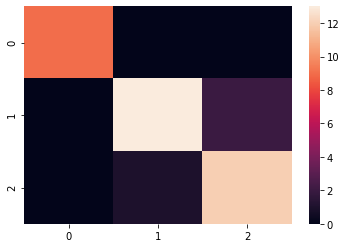

In [72]:
#df1
cls_0,cox = xgbtrain(df1)
print(cls_0)
sns.heatmap(cox)

3
              precision    recall  f1-score   support

           1       0.84      0.97      0.90        33
           2       0.80      0.97      0.88        33
           3       0.97      0.70      0.82        44

    accuracy                           0.86       110
   macro avg       0.87      0.88      0.86       110
weighted avg       0.88      0.86      0.86       110



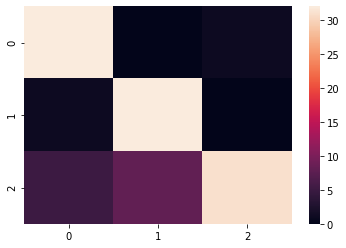

In [73]:
#df1 aug
cls_0,cox = xgbtrain(df1_aug)
print(cls_0)
sns.heatmap(cox)